# 1. Model tuning

## 1.1. Giới thiệu bài toán
Xây dựng mô hình nhận dạng ảnh trang phục, gồm các loại trang phục như: Sneaker, Shirt, Dress,...

## 1.2. Bộ dữ liệu fashion MNIST
Bài tập này sử dụng tập dữ liệu Fashion MNIST chứa 70.000 hình ảnh đen trắng gồm một kênh màu được chia thành 10 danh mục khác nhau. Mỗi hình ảnh hiển thị một mặt hàng quần áo ở độ phân giải thấp (28x28 pixel), như trong ví dụ minh hoạ:

<img src="https://www.tensorflow.org/images/fashion-mnist-sprite.png">

Ở đây, 60.000 hình ảnh được sử dụng để huấn luyện và 10.000 hình ảnh để đánh giá mức độ chính xác. Chúng ta có thể tải trực tiếp bộ dữ liệu Fashion MNIST trực tiếp từ TensorFlow.

Thao tác nhập và tải dữ liệu Fashion MNIST trực tiếp từ TensorFlow như sau:

In [ ]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Dữ liệu trả về gồm bốn mảng NumPy array:

- Mảng <code>train_images</code> và <code>train_labels</code> là tập huấn luyện - dữ liệu mà mô hình sử dụng để học.
- Mô hình được kiểm thử trên tập kiểm thử, mảng <code>test_images</code> và <code>test_labels</code>.

Mỗi hình ảnh là một NumPy array 28x28, với các giá trị pixel nằm trong khoảng từ 0 đến 255. Các nhãn là một mảng các số nguyên, từ 0 đến 9. Các nhãn này tương ứng với loại quần áo mà hình ảnh đại diện:

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Mỗi hình ảnh được ánh xạ tới một nhãn duy nhất. Vì tên lớp không được bao gồm trong tập dữ liệu, chúng ta lưu trữ chúng ở đây để sử dụng sau này khi vẽ biểu đồ hình ảnh:

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 1.3. Phân tích dữ liệu

Hãy cùng phân tích định dạng của tập dữ liệu trước khi huấn luyện mô hình. Phần sau cho thấy có 60.000 hình ảnh trong tập huấn luyện, với mỗi hình ảnh được biểu thị là 28 x 28 pixel:

In [ ]:
train_images.shape

(60000, 28, 28)

Tương tự như vậy, có 60.000 nhãn trong tập huấn luyện:

In [ ]:
len(train_labels)

60000

Mỗi nhãn là một số nguyên từ 0 đến 9:

In [ ]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Có 10.000 hình ảnh trong tập kiểm thử. Một lần nữa, mỗi hình ảnh được biểu thị dưới dạng 28 x 28 pixel:

In [ ]:
test_images.shape

(10000, 28, 28)

Và tập kiểm thử chứa 10.000 nhãn hình ảnh:

In [ ]:
len(test_labels)

10000

## 1.4. Tiền xử lý dữ liệu

Dữ liệu phải được xử lý trước trước khi huấn luyện mạng nơ ron. Nếu ta kiểm tra hình ảnh đầu tiên trong tập huấn luyện, ta sẽ thấy rằng các giá trị pixel nằm trong khoảng từ 0 đến 255:

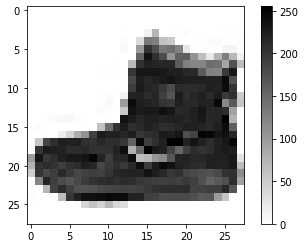

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(train_images[0], plt.cm.binary)
plt.colorbar()
plt.show()

Chuẩn hoá các giá trị này về giá trị từ 0 đến 1 trước khi đưa chúng vào mô hình mạng nơ ron. Để làm như vậy, chúng ta sử dụng min-max feature scaling để chuẩn hoá như sau:

$x'=\frac{x-x_{min}}{x_{max} - x_{min}}$

Ở đây $x_{min}=0$ và $x_{max}=255$ nên ta chỉ cần chia các giá trị cho 255. Điều quan trọng là tập huấn luyện và tập kiểm thử phải được xử lý trước theo cùng một cách:

In [ ]:
train_images = train_images / 255.0

test_images = test_images / 255.0

Để xác minh rằng dữ liệu ở đúng định dạng và bạn đã sẵn sàng xây dựng và huấn luyện mạng nơ ron, chúng ta hiển thị 25 hình ảnh đầu tiên từ tập huấn luyện và hiển thị tên lớp bên dưới mỗi hình ảnh.

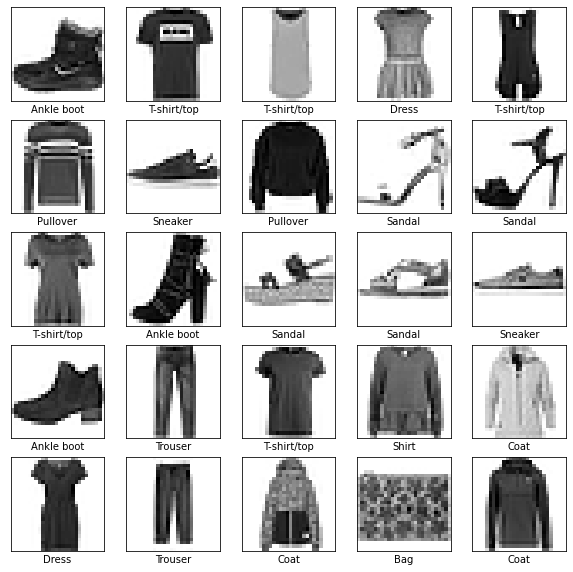

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## 1.5. Xây dựng mô hình mạng nơ ron đơn giản

Trong phần đầu tiên, chúng ta cùng xây dựng lại một mạng nơ ron đơn giản nhất - mạng nơ ron kết nối đầy đủ trên tập dữ liệu này.

Xây dựng mạng nơ ron cần xác định cấu hình các lớp của mô hình, sau đó biên dịch mô hình.

### 1.5.1. Thiết lập mô hình
Ta dựng một mạng nơ ron cơ bản gồm
- 1 tầng đầu vào 28x28 được làm phẳng thành một vecto 784 chiều.
- 1 tầng ẩn có 128 units, hàm kích hoạt relu.
- 1 tầng đầu ra 10 units tương ứng với 10 lớp.

Mạng được định nghĩa như sau:

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

Để kiểm tra các thông số mô hình ta dùng hàm summary như sau:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### 1.5.2. Biên dịch mô hình
Trước khi mô hình sẵn sàng để huấn luyện, ta cần thêm một số cài đặt. Chúng được thêm vào trong bước biên dịch của mô hình:

- Hàm mất mát - loss function.
- Bộ tối ưu - optimizer.
- Các độ đo - metrics.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 1.5.3. Huấn luyện mô hình

Cung cấp dữ liệu huấn luyện vào mô hình. Trong ví dụ này, dữ liệu huấn luyện nằm trong mảng train_images và train_labels.

Để bắt đầu huấn luyện, chúng ta gọi phương thức model.fit:

In [ ]:
# initial_weights = model.get_weights() # save initial_weights for restoration
# model.fit(train_images, train_labels, epochs=10)

Khi huấn luyện mô hình, các số liệu về hàm mất mát và độ chính xác được hiển thị. Mô hình này đạt độ chính xác khoảng 0.91 (91%) trên dữ liệu huấn luyện.

### 1.5.4. Trực quan hoá quá trình huấn luyện với tensorboard callback

Để trực quan hoá quá trình huấn luyện, sự thay đổi của tham số cũng như hàm mất mát và các độ đo. Chúng ta sử dụng tensorboard callback để lưu lại lịch sử chi tiết. Lưu ý: việc này có thể làm chậm quá trình huấn luyện mô hình.

In [ ]:
# model.set_weights(initial_weights) # restore the initial_weights

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=1, write_graph=True,
    write_images=True, update_freq=1
)
model.fit(train_images, train_labels, epochs=10, callbacks=[tensorboard_callback])

Epoch 1/10
1875/1875 [==============================] - 7s 2ms/step - loss: 0.4947 - accuracy: 0.8248
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3724 - accuracy: 0.8669
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3353 - accuracy: 0.8784
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3119 - accuracy: 0.8853
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2938 - accuracy: 0.8903
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2793 - accuracy: 0.8977
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2670 - accuracy: 0.9012
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2572 - accuracy: 0.9048
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2474 - accuracy: 0.9084
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.238

Một cách khác để xem sự thay đổi của mô hình là lấy trực tiếp tham số của mô hình sau từng bước huấn luyện như sau:

In [ ]:
model.get_weights()

[array([[ 0.04009643, -0.02915703, -0.0654712 , ...,  0.083328  ,
         -0.1774987 , -0.29489124],
        [ 0.15806586, -0.21689421, -0.2264374 , ..., -0.22609636,
         -0.30017182,  0.07326886],
        [ 0.2674951 , -0.20769672, -0.20509186, ..., -0.24806914,
         -0.28947577, -0.21092713],
        ...,
        [-0.05858126,  0.07770675, -0.12997685, ..., -0.04147777,
         -0.08929964, -0.17485945],
        [-0.05592308,  0.0509623 , -0.3128455 , ..., -0.02159997,
         -0.03515062, -0.74825144],
        [ 0.20628986,  0.21141592, -0.23933156, ...,  0.19514474,
          0.22709528, -0.6618782 ]], dtype=float32),
 array([ 4.71359789e-01,  2.12358370e-01,  6.30354464e-01,  5.02301514e-01,
         4.76912528e-01,  1.16453558e-01,  3.13877851e-01,  6.16391778e-01,
        -1.43431434e-02,  1.99108317e-01,  4.21499342e-01,  5.89160144e-01,
        -1.10108562e-01,  3.31381679e-01, -1.25540629e-01,  1.13178559e-01,
         4.10392731e-01, -2.56590039e-01,  6.62978142e

### 1.5.5. Đánh giá độ chính xác

Tiếp theo, so sánh cách mô hình hoạt động trên tập dữ liệu kiểm thử:

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3525 - accuracy: 0.8774 - 669ms/epoch - 2ms/step

Test accuracy: 0.8773999810218811


### 1.5.6. Dự đoán

Với mô hình đã được huấn luyện, chúng ta có thể sử dụng nó để đưa ra dự đoán về một số hình ảnh. Các đầu ra của mô hình là các giá trị tuyến tính - logits. Thêm một tầng softmax để chuyển đổi nhật ký thành xác suất, dễ diễn giải hơn, như sau:

In [ ]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)

313/313 [==============================] - 0s 1ms/step


Ở đây, mô hình đã dự đoán nhãn cho từng hình ảnh trong bộ thử nghiệm. Hãy cùng xem dự đoán đầu tiên:

In [ ]:
predictions[0]

array([3.8751796e-06, 5.0554057e-08, 6.2946209e-10, 3.1925165e-09,
       3.0011347e-09, 1.6208517e-04, 1.2588330e-06, 2.8113476e-03,
       2.8262372e-07, 9.9702114e-01], dtype=float32)

Dự đoán là một dãy 10 số. Chúng đại diện cho "độ chắc chắn" của mô hình rằng hình ảnh tương ứng với mỗi trong số 10 sản phẩm quần áo khác nhau. Bạn có thể xem nhãn nào có giá trị cao nhất bằng cách dùng hàm argmax:

In [ ]:
import numpy as np

np.argmax(predictions[0])

9

Vì vậy, mô hình dự đoán hình ảnh này là "ankle boot" tương ứng là <code>class_names[9]</code>. Kiểm tra nhãn thử nghiệm cho thấy rằng phân loại này là chính xác:

In [ ]:
test_labels[0]

9

Hai hàm dưới đây được định nghĩa để hình dung rõ hơn về các dự đoán

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Chúng ta vẽ một số hình ảnh với dự đoán của chúng. Lưu ý rằng mô hình có thể sai ngay cả khi rất tự tin.

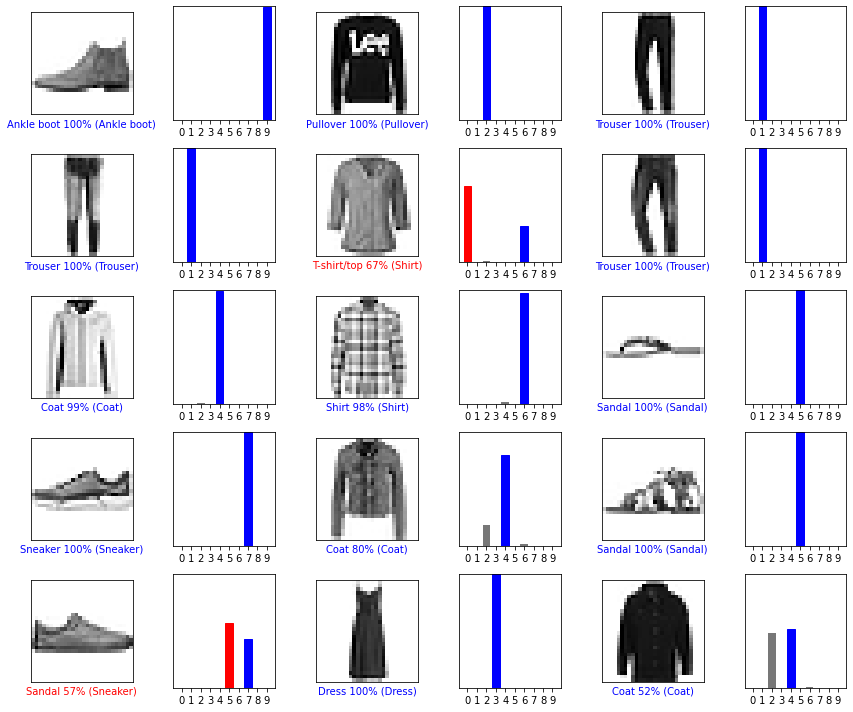

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## 1.6. Thay đổi mô hình - mạng nơ ron tích chập

Trong ví dụ trên, mô hình mạng nơ ron được sử dụng để phân lớp là mạng nơ ron kết nối đầy đủ. Mô hình này dường như chưa thực sự phù hợp với dữ liệu là ảnh. Do đó, trước khi bắt đầu bất kỳ quá trình tuning mô hình nào, ta cần lựa chọn được một kiến trúc mô hình phù hợp. Ở đây, dữ liệu là ảnh, dựa trên kinh nghiệm có thể dự đoán là mô hình mạng nơ ron tích chập sẽ có hiệu quả.

Chúng ta cùng xây dựng một mạng nơ ron tích chập trên tập dữ liệu này gồm:
- đầu vào là ảnh kích thước 28x28 đã được mở rộng thêm 1 chiều kênh màu 28x28x1.
- 1 tầng Convolution 2D với hàm kích hoạt relu.
- 1 tầng MaxPooling 2D.
- 1 tầng đầu ra gồm 10 units tương ứng với 10 lớp.

Do đầu vào của mạng nơ ron tích chập cần thêm 1 chiều, tương ứng là số kênh màu của ảnh. Ta tăng thêm một chiều cho dữ liệu. Mô hình mạng nơ ron tích chập được định nghĩa như sau:

In [ ]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

cnn_model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

Ở đây, ta sử dụng hàm activation softmax trực tiếp để tránh định nghĩa thêm một mô hình khác để dự đoán.

Các tham số của mô hình được tổng hợp như sau:

In [ ]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 2704)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                27050     
                                                                 
Total params: 27,210
Trainable params: 27,210
Non-trainable params: 0
__________________________________________________

Quá trình huấn luyện mô hình được thực hiện tương tự. Tuy nhiên, trong thí nghiệm này, tập dữ liệu kiểm thử được truyền trực tiếp vào hàm fit để làm dữ liệu kiểm tra sau mỗi epoch huấn luyện mô hình.

In [ ]:
cnn_model.fit(train_images, train_labels, epochs=10, validation_data = (test_images, test_labels))

Epoch 1/10
1875/1875 [==============================] - 12s 3ms/step - loss: 0.4752 - accuracy: 0.8336 - val_loss: 0.3982 - val_accuracy: 0.8594
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3413 - accuracy: 0.8814 - val_loss: 0.3433 - val_accuracy: 0.8807
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3080 - accuracy: 0.8918 - val_loss: 0.3470 - val_accuracy: 0.8766
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2841 - accuracy: 0.8998 - val_loss: 0.3054 - val_accuracy: 0.8920
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2663 - accuracy: 0.9057 - val_loss: 0.3024 - val_accuracy: 0.8942
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2514 - accuracy: 0.9113 - val_loss: 0.2965 - val_accuracy: 0.8933
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2402 - accuracy: 0.9148 - val_loss: 0.2926 - val_accuracy

Kết quả cho thấy rằng, chỉ cần thay đổi kiến trúc mô hình, kết quả đạt được 2 thay đổi sau:
- Số lượng tham số giảm đi đáng kể: từ 101,770 xuống 27,210.
- Kết quả kiểm thử tăng lên rõ rệt.

Tuy nhiên, liệu mô hình như vậy đã đủ tốt? Làm sao để tiếp tục tăng kết quả của mô hình? Một câu trả lời là chúng ta có thể tinh chỉnh siêu tham số (hyperparameter) của mô hình phù hợp với dữ liệu để cho kết quả tốt hơn.

## 1.7. Tinh chỉnh siêu tham số với Keras tuner

Keras Tuner là một thư viện giúp chúng ta chọn bộ siêu tham số tối ưu cho mô hình viết bằng TensorFlow của mình.

Siêu tham số là các biến chi phối quá trình huấn luyện và cấu trúc của mô hình học máy. Các biến này không đổi trong quá trình huấn luyện và tác động trực tiếp đến hiệu suất của mô hình. Siêu tham số có hai loại:

- Các siêu tham số của mô hình: ảnh hưởng đến việc lựa chọn mô hình chẳng hạn như số lượng và kích thước của các tầng ẩn
- Các siêu tham số của thuật toán: ảnh hưởng đến tốc độ và chất lượng của thuật toán huấn luyện, chẳng hạn như tốc độ học  của Stochastic Gradient Descent (SGD) và số lượng hàng xóm gần nhất đối với bộ phân loại k Nearest Neighbors (KNN).

### 1.7.1. Cài đặt

Cài đặt và import Keras Tuner.

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 135 kB 6.5 MB/s 
     |████████████████████████████████| 1.6 MB 52.5 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


### 1.7.2. Định nghĩa siêu mô hình

Khi chúng ta xây dựng một mô hình cho để tuning, chúng ta cần xác định không gian tìm kiếm hyperparameter ngoài việc định nghĩa  kiến trúc mô hình. Mô hình chúng ta thiết lập để tinh chỉnh siêu tham số được gọi là siêu mô hình (hypermodel).

Trong hướng dẫn này, chúng ta sử dụng hàm <code>model_builder</code> để xác định mô hình phân loại hình ảnh. Hàm này khởi tạo và trả về một mô hình đã biên dịch và sử dụng các siêu tham số mà bạn xác định.

Một định nghĩa đầu tiên như sau:

In [ ]:
def build_model(hp):  # random search passes this hyperparameter() object 
    _model = tf.keras.models.Sequential()
    
    _model.add(tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28))),
    _model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu'))
    _model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    _model.add(tf.keras.layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
    _model.add(tf.keras.layers.Dense(10, activation='softmax'))

    _model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return _model

Lưu ý rằng chúng ta không huấn luyện mô hình ở hàm này mà trả về mô hình đã biên dịch. Trước tiên, hãy tiếp tục xây dựng phần còn lại của chương trình, sau đó chúng ta sẽ làm cho mô hình **dynamic** hơn.

Đầu tiên chúng ta sẽ xác định bộ tinh chỉnh siêu tham số:

In [ ]:
tuner = kt.tuners.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,  # how many model variations to test?
    executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
    directory='tuning_logs')

<code>objective</code> ở đây sử dụng độ chính xác trên tập validation - val_accuracy, nhưng ta có thể chọn val_loss thay thế.

<code>max_trials</code> cho phép ta giới hạn số lượng lần thử sẽ được chạy. Nếu ta đặt 10 ở đây, ta sẽ nhận được 10 thử nghiệm khác nhau (với điều kiện là ta có đủ 10 phiên bản khác nhau để thử).

<code>execute_per_trial</code> có thể là 1, nhưng ta cũng có thể tăng lên 3, 5 hoặc thậm chí 10.

Về cơ bản, nếu ta chỉ tìm kiếm một mô hình hoạt động được, thì ta chỉ nên thử 1 lần cho mỗi biến thể. Nếu ta cần kiểm tra độ ổn đinh, thì rất có thể ta nên chạy hơn 3 lần thử cho mỗi mô hình, bởi vì mỗi khi một mô hình chạy kết quả sẽ có sự thay đổi nhất định.

Để xem thống kê của bộ tinh chỉnh siêu tham số ta thực hiện:

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 0


Tất nhiên, chúng ta không có bất kỳ không gian tìm kiếm nào, bởi vì chúng ta không xác định biến thể nào (việc này sẽ được thử ở phần tiếp theo).

Bây giờ, chúng ta sẽ thực hiện tìm kiếm:

In [ ]:
tuner.search(x=train_images,
             y=train_labels,
             verbose=2, # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=1,
             batch_size=64,
             #callbacks=[tensorboard],  # if you have callbacks like tensorboard, they go here.
             validation_data=(test_images, test_labels))

Trial 1 Complete [00h 00m 06s]
val_accuracy: 0.8533999919891357

Best val_accuracy So Far: 0.8533999919891357
Total elapsed time: 00h 00m 06s


Chúng tôi đã có thể thấy ~ quá trình tinh chỉnh đã thực hiện như thế nào, nhưng chúng ta cũng có thể in ra một bản tóm tắt như sau:

In [ ]:
tuner.results_summary()

Results summary
Results in tuning_logs/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
default configuration
Score: 0.8533999919891357


Tất nhiên, điều này là khá vô nghĩa. Chúng ta sẽ làm cho mô hình này **dynamic hơn**. Chúng ta sẽ bắt đầu bằng cách thử nghiệm trên tầng tích chập:

```py
_model.add(Conv2D(16, (3, 3), input_shape=x_train.shape[1:]))
```

Số lượng filters đang được cố định là 16, chúng ta sẽ cùng thử thay đổi để tìm ra một số lượng filter tối ưu hơn. Giả sử, chúng ta muốn thử nghiệm số lượng filter là 16, 32 và 64; chúng ta sẽ có một cài đặt như sau:

```py
hp.Choice('filter', values = [16, 32, 64]) 
```

Khi đó câu lệnh trở thành:
```py
_model.add(Conv2D(hp.Choice('filter', values = [16, 32, 64]),
                  (3, 3), input_shape=x_train.shape[1:]))
```

Hàm <code>build_model</code> trở thành:

In [ ]:
def build_model2(hp):  # random search passes this hyperparameter() object 
    _model = tf.keras.models.Sequential()
    
    _model.add(tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28))),
    _model.add(tf.keras.layers.Conv2D(hp.Choice('filter', values = [16, 32, 64]),
                                      (3, 3), activation='relu'))
    _model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    _model.add(tf.keras.layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
    _model.add(tf.keras.layers.Dense(10, activation='softmax'))

    _model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return _model

Thực hiện lại quá trình tinh chỉnh tham số ta được:

In [ ]:
tuner2 = kt.tuners.RandomSearch(
    build_model2,
    objective='val_accuracy',
    max_trials=10,  # how many model variations to test?
    executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
    directory='tuning_logs_2')
tuner2.search_space_summary()

Search space summary
Default search space size: 1
filter (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}


In [ ]:
tuner2.search(x=train_images,
             y=train_labels,
             verbose=2, # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=1,
             batch_size=64,
             #callbacks=[tensorboard],  # if you have callbacks like tensorboard, they go here.
             validation_data=(test_images, test_labels))

Trial 3 Complete [00h 00m 06s]
val_accuracy: 0.8521000146865845

Best val_accuracy So Far: 0.8705999851226807
Total elapsed time: 00h 00m 17s


In [ ]:
tuner2.results_summary()

Results summary
Results in tuning_logs_2/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
filter: 64
Score: 0.8705999851226807
Trial summary
Hyperparameters:
filter: 32
Score: 0.8687999844551086
Trial summary
Hyperparameters:
filter: 16
Score: 0.8521000146865845


Để lấy ra bộ giá trị tối ưu:

In [ ]:
best_hps = tuner2.get_best_hyperparameters()[0]
best_hps.values

{'filter': 64}

Để lấy ra thông tin của mô hình tối ưu:

In [ ]:
tuner2.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense (Dense)               (None, 10)                108170    
                                                                 
Total params: 108,810
Trainable params: 108,810
Non-trainable params: 0
__________________________________________________

Để dựng lại mô hình tối ưu và huấn luyện lại mô hình trên dữ liệu:

In [ ]:
tuned_model = tuner2.hypermodel.build(best_hps)
tuned_model.fit(train_images, train_labels, epochs=10, validation_data = (test_images, test_labels))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4129 - accuracy: 0.8553 - val_loss: 0.3255 - val_accuracy: 0.8835
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2944 - accuracy: 0.8953 - val_loss: 0.3020 - val_accuracy: 0.8941
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2613 - accuracy: 0.9065 - val_loss: 0.2844 - val_accuracy: 0.8990
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2359 - accuracy: 0.9158 - val_loss: 0.2731 - val_accuracy: 0.9044
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2162 - accuracy: 0.9220 - val_loss: 0.2716 - val_accuracy: 0.9032
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1977 - accuracy: 0.9289 - val_loss: 0.2656 - val_accuracy: 0.9067
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1837 - accuracy: 0.9330 - val_loss: 0.2637 - val_accuracy:

### 1.7.3. Một số ví dụ

Dưới đây là ví dụ của các tham số có thể tinh chỉnh:

- Lựa chọn hyp trong [16, 32, 64]:
```py
hp.Choice('hyp', values = [16, 32, 64])
```

- Lựa chọn hyp trong trong khoảng từ 16 đến 128, bước nhảy 16. Giá trị có thể có là [16, 32, ..., 128]:
```py
hp.Int('hyp',
        min_value=16,
        max_value=128,
        step=16)
```

- Lựa chọn số tầng convolution từ 1 đến 4:
```py
for i in range(hp.Int('n_layers', 1, 4)):
    _model.add(Conv2D(16, (3, 3), input_shape=x_train.shape[1:]))
```

- Lựa chọn thuật toán huấn luyện từ ['adam', 'sgd']:
```py
optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
```

- Lựa chọn tốc độ học trong [0.01, 0.001, 0.0001, 0.00001]:
```py
hp.Choice('lr', values = [0.01, 0.001, 0.0001, 0.00001])
```

In [ ]:
# # Your task is define a hypermodel and search for optimal hyperparameters here
# def build_model3(hp):  # random search passes this hyperparameter() object 
#     _model = tf.keras.models.Sequential()
    
#     _model.add(tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28))),
#     _model.add(tf.keras.layers.Conv2D(hp.Choice('filter', values = [16, 32, 64]),
#                                       (3, 3), activation='relu'))
#     _model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#     _model.add(tf.keras.layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
#     _model.add(tf.keras.layers.Dense(10, activation='softmax'))

#     _model.compile(optimizer="adam",
#                   loss="sparse_categorical_crossentropy",
#                   metrics=["accuracy"])
#     return _model

# tuner3 = kt.tuners.RandomSearch(
#     build_model3,
#     objective='val_accuracy',
#     max_trials=10,  # how many model variations to test?
#     executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
#     directory='tuning_logs_3')
# tuner3.search_space_summary()

# tuner3.search(x=train_images,
#              y=train_labels,
#              verbose=2, # just slapping this here bc jupyter notebook. The console out was getting messy.
#              epochs=1,
#              batch_size=64,
#              #callbacks=[tensorboard],  # if you have callbacks like tensorboard, they go here.
#              validation_data=(test_images, test_labels))

# 2. Một số kỹ thuật nâng cao hiệu suất mô hình

Trong phần này, ta sử dụng lại mô hình mạng nơ ron kết nối đầy đủ để thử nghiệm các kỹ thuật nâng cao hiệu suất mô hình.

Mô hình cơ sở được định nghĩa như sau:

In [ ]:
mlp_model_0 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
mlp_model_0.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
mlp_model_0.fit(train_images, train_labels, epochs=10, validation_data = (test_images, test_labels))

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4931 - accuracy: 0.8262 - val_loss: 0.4158 - val_accuracy: 0.8527
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3726 - accuracy: 0.8656 - val_loss: 0.4055 - val_accuracy: 0.8512
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3370 - accuracy: 0.8759 - val_loss: 0.3610 - val_accuracy: 0.8691
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3120 - accuracy: 0.8849 - val_loss: 0.3647 - val_accuracy: 0.8715
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2937 - accuracy: 0.8907 - val_loss: 0.3738 - val_accuracy: 0.8665
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2804 - accuracy: 0.8960 - val_loss: 0.3486 - val_accuracy: 0.8752
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2675 - accuracy: 0.9004 - val_loss: 0.3415 - val_accuracy:

## 2.1. Dropout

Tầng Dropout ngẫu nhiên chuyển các units đầu vào thành 0 với tần suất <code>rate</code> ở mỗi bước trong quá trình huấn luyện, điều này giúp giảm overfitting. Các đầu vào không được đặt thành 0 được scale lại theo tỷ lệ $1 / (1 - rate)$ sao cho tổng trên tất cả các đầu vào không thay đổi.

In [ ]:
tf.random.set_seed(0)
layer = tf.keras.layers.Dropout(.2, input_shape=(2,))
data = np.arange(10).reshape(5, 2).astype(np.float32)
print(data)
outputs = layer(data, training=True)
print(outputs)

[[0. 1.]
 [2. 3.]
 [4. 5.]
 [6. 7.]
 [8. 9.]]
tf.Tensor(
[[ 0.    1.25]
 [ 2.5   3.75]
 [ 5.    6.25]
 [ 7.5   8.75]
 [10.    0.  ]], shape=(5, 2), dtype=float32)


Áp dụng tầng Dropout vào sau tầng ẩn thứ nhất như sau:

In [ ]:
mlp_model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])
mlp_model_1.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
mlp_model_1.fit(train_images, train_labels, epochs=10, validation_data = (test_images, test_labels))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6204 - accuracy: 0.7824 - val_loss: 0.4685 - val_accuracy: 0.8266
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4735 - accuracy: 0.8290 - val_loss: 0.4184 - val_accuracy: 0.8491
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4425 - accuracy: 0.8408 - val_loss: 0.3994 - val_accuracy: 0.8513
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4166 - accuracy: 0.8480 - val_loss: 0.3875 - val_accuracy: 0.8584
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4065 - accuracy: 0.8524 - val_loss: 0.3742 - val_accuracy: 0.8628
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3929 - accuracy: 0.8572 - val_loss: 0.3868 - val_accuracy: 0.8583
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3868 - accuracy: 0.8601 - val_loss: 0.3709 - val_accuracy:

## 2.3. Initializer

Hàm khởi tạo tham số mặc định (thông thường của các tầng trong tf.keras.layers) là <code>glorot_uniform</code>. Hàm này lấy mẫu từ một phân bố đều trong khoảng $[-limit, limit]$, trong đó $limit = sqrt (6 / (fan\_in + fan\_out))$ trong đó $fan\_in$ là số units đầu vào và $fan\_out$ là số units đầu ra.

Một hàm khởi tạo khác là <code>glorot_normal</code>. Hàm này lấy mẫu từ phân phối chuẩn kỳ vọng là 0 và độ lệch chuẩn $stddev = sqrt (2 / (fan\_in + fan\_out))$ trong đó $fan\_in$ là số units đầu vào và $fan\_out$ là số units đầu ra.

In [ ]:
# Standalone usage:
initializer = tf.keras.initializers.GlorotNormal()
values = initializer(shape=(2, 2))
print(values)

# Usage in a Keras layer:
initializer = tf.keras.initializers.GlorotNormal()
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

tf.Tensor(
[[ 1.3657607  -0.6215701 ]
 [ 0.22307043 -0.38971162]], shape=(2, 2), dtype=float32)


## 2.4. Regularization

Regularizers cho phép ta áp dụng các "hình phạt" đối với các tham số mô hình hoặc hoạt động của các tầng trong quá trình tối ưu hóa. Các hình phạt này được cộng vào hàm mất mát mà mạng nơ ron tối ưu hóa. Như vậy, các tham số, hoạt động này sẽ có giá trị nhỏ xung quanh 0.

Có 3 đối số tương ứng là:
- kernel_regularizer: điều chỉnh tham số mô hình W.
- bias_regularizer: điều chỉnh bias mô hình b.
- activity_regularizer: điều chỉnh đầu ra của tầng.

Ví dụ sau đây thử áp dụng L2-norm với tầng đầu ra của mạng nơ-ron trên:

In [ ]:
mlp_model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer='l2', bias_regularizer='l2')
])
mlp_model_2.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
mlp_model_2.fit(train_images, train_labels, epochs=10, validation_data = (test_images, test_labels))

mlp_model_2.get_weights()

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6069 - accuracy: 0.8192 - val_loss: 0.5172 - val_accuracy: 0.8383
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4566 - accuracy: 0.8574 - val_loss: 0.4788 - val_accuracy: 0.8468
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4143 - accuracy: 0.8683 - val_loss: 0.4369 - val_accuracy: 0.8591
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3872 - accuracy: 0.8772 - val_loss: 0.4406 - val_accuracy: 0.8534
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3713 - accuracy: 0.8807 - val_loss: 0.4168 - val_accuracy: 0.8639
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3557 - accuracy: 0.8864 - val_loss: 0.3964 - val_accuracy: 0.8721
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3461 - accuracy: 0.8881 - val_loss: 0.3841 - val_accuracy:

[array([[ 0.02013555, -0.08963859,  0.17583619, ...,  0.05926689,
         -0.0157219 ,  0.08431061],
        [ 0.1633405 , -0.22540314,  0.25911593, ...,  0.25571913,
          0.30668017,  0.41701758],
        [-0.19118822, -0.4302873 ,  0.24642274, ...,  0.32355046,
          0.18276262,  0.13812336],
        ...,
        [-0.34736887, -0.11622997,  0.36908677, ...,  0.40026027,
          0.3107366 , -0.33834195],
        [ 0.1203046 , -0.15880041,  0.25327528, ...,  0.19054979,
          0.0123996 , -0.47595066],
        [ 0.10499261, -0.3382926 ,  0.26364997, ...,  0.06659501,
          0.22503053, -0.33014315]], dtype=float32),
 array([ 3.5862717e-01,  1.5508808e-01,  1.0106133e+00,  1.1649373e+00,
        -2.7572667e-02,  8.3699560e-01,  8.1295335e-01, -7.2679199e-02,
        -4.7566333e-01, -4.7971526e-01, -7.1881884e-01,  5.8336571e-02,
         9.0585977e-01,  3.8781208e-01, -1.0865530e+00, -3.2213718e-02,
         3.6466993e-02,  3.7570402e-01, -4.1707197e-01,  1.0805912e+00

## 2.5. Early Stopping

Dừng huấn luyện mô hình khi một chỉ số được giám sát ngừng cải thiện.

Giả sử mục tiêu của việc huấn luyện là tối thiểu hoá hàm mất mát. Khi đó, chỉ số được giám sát sẽ là 'loss' và chế độ sẽ là 'min'. Vòng lặp huấn luyện <code>model.fit()</code> sẽ kiểm tra vào cuối mỗi epoch xem hàm mất mát còn giảm nữa hay không, xem xét <code>min_delta</code> và <code>patience</code> nếu có. Khi nó không còn giảm nữa, <code>model.stop_training</code> được đánh dấu là <code>True</code> và quá trình huấn luyện kết thúc.

In [ ]:
mlp_model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2', bias_regularizer='l2'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer='l2', bias_regularizer='l2')
])
mlp_model_3.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
mlp_model_3.fit(train_images, train_labels, epochs=30, validation_data = (test_images, test_labels), callbacks=[es_callback])

Epoch 1/30
1875/1875 [==============================] - 6s 3ms/step - loss: 1.2008 - accuracy: 0.7402 - val_loss: 0.9328 - val_accuracy: 0.7767
Epoch 2/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.9967 - accuracy: 0.7614 - val_loss: 0.9301 - val_accuracy: 0.7909
Epoch 3/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.9900 - accuracy: 0.7634 - val_loss: 0.9124 - val_accuracy: 0.7979
Epoch 4/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.9887 - accuracy: 0.7638 - val_loss: 0.9394 - val_accuracy: 0.7855
Epoch 5/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.9881 - accuracy: 0.7641 - val_loss: 0.9291 - val_accuracy: 0.7773


# 3. Bộ học kết hợp

## 3.1. Voting

Ta dùng 3 mô hình cơ sở như sau để thực hiện voting:

**Mô hình 1**: mạng MLP 1 tầng ẩn.

In [ ]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_1.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
model_1.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5008 - accuracy: 0.8239
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3752 - accuracy: 0.8659
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3378 - accuracy: 0.8768
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3134 - accuracy: 0.8850
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2972 - accuracy: 0.8902
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2807 - accuracy: 0.8964
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2702 - accuracy: 0.8991
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2586 - accuracy: 0.9055
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2474 - accuracy: 0.9079
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.239

**Mô hình 2**: mạng CNN đơn giản.

In [ ]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_2.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
model_2.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4659 - accuracy: 0.8381
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3354 - accuracy: 0.8834
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3016 - accuracy: 0.8941
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2787 - accuracy: 0.9025
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2630 - accuracy: 0.9074
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2494 - accuracy: 0.9128
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2373 - accuracy: 0.9161
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2288 - accuracy: 0.9187
Epoch 9/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2197 - accuracy: 0.9211
Epoch 10/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.212

**Mô hình 3**: Hồi quy logistic.

In [ ]:
from sklearn.linear_model import LogisticRegression
model_3 = LogisticRegression()
model_3.fit(train_images.reshape(-1, 28*28), train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

Dự đoán của từng mô hình đơn lẻ:

In [ ]:
predictions_1 = model_1.predict(test_images)
predictions_2 = model_2.predict(test_images)
predictions_3 = model_3.predict_proba(test_images.reshape(-1, 28*28))

313/313 [==============================] - 1s 2ms/step


Tính toán độ chính xác của các mô hình đơn lẻ:

In [ ]:
from sklearn.metrics import accuracy_score

classes_1 = np.argmax(predictions_1, axis=-1)
classes_2 = np.argmax(predictions_2, axis=-1)
classes_3 = np.argmax(predictions_3, axis=-1)

print('model 1 acc:', accuracy_score(test_labels, classes_1))
print('model 2 acc:', accuracy_score(test_labels, classes_2))
print('model 3 acc:', accuracy_score(test_labels, classes_3))

model 1 acc: 0.884
model 2 acc: 0.8984
model 3 acc: 0.8439


**Cách 1**: dự đoán dựa trên nhãn cuối cùng.

In [ ]:
from scipy import stats

voted_1 = stats.mode([classes_1, classes_2, classes_3])[0][0]
print('vote 1 acc:', accuracy_score(test_labels, voted_1))

vote 1 acc: 0.8899


**Cách 2**: dự đoán dựa trên độ tin cậy mô hình.

In [ ]:
predictions_v = predictions_1 + predictions_2 + predictions_3
voted_2 = np.argmax(predictions_v, axis=-1)

print('vote 2 acc:', accuracy_score(test_labels, voted_2))

vote 2 acc: 0.8974


# 4. Xử lý vấn đề không cân bằng dữ liệu

## 4.2. Weighted Training Loss

Một trong các cách để xử lý vấn đề không cân bằng dữ liệu là sử dụng hàm mất mát có trọng số. Trọng số của một lớp được tính dựa trên số lượng ví dụ của lớp đó. Lớp ít dữ liệu trọng số lớn hơn và ngược lại.

Giả sử, số lượng dữ liệu cho từng nhãn tương ứng như sau (thực tế tập dữ liệu này cân bằng):

In [ ]:
example_count = {
    0: 1500,
    1: 2500,
    2: 3500,
    3: 4500,
    4: 5500,
    5: 6500,
    6: 7500,
    7: 8500,
    8: 9500,
    9: 10500,
}
total = sum(example_count.values())

weight_1 = {k: total/example_count[k] for k in example_count}

# Scaling by total/num of class helps keep the loss to a similar magnitude.
weight_2 = {k: total/example_count[k]/len(example_count) for k in example_count}
print('weight 1:', weight_1)
print('weight 2:', weight_2)

weight 1: {0: 40.0, 1: 24.0, 2: 17.142857142857142, 3: 13.333333333333334, 4: 10.909090909090908, 5: 9.23076923076923, 6: 8.0, 7: 7.0588235294117645, 8: 6.315789473684211, 9: 5.714285714285714}
weight 2: {0: 4.0, 1: 2.4, 2: 1.7142857142857142, 3: 1.3333333333333335, 4: 1.0909090909090908, 5: 0.923076923076923, 6: 0.8, 7: 0.7058823529411764, 8: 0.631578947368421, 9: 0.5714285714285714}


Sử dụng mô hình này trong huấn luyện mô hình như sau:

In [ ]:
model_w = tf.keras.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_w.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model_w.fit(train_images, train_labels, epochs=10, class_weight=weight_2)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6212 - accuracy: 0.8187
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4495 - accuracy: 0.8686
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4019 - accuracy: 0.8834
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3715 - accuracy: 0.8906
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3500 - accuracy: 0.8972
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3323 - accuracy: 0.9023
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3177 - accuracy: 0.9064
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3048 - accuracy: 0.9098
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2928 - accuracy: 0.9125
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.283